### **ANGGOTA KELOMPOK**
**1. M.ZHAFIR ZAYDAN (21.11.3913)**                                
**2. VIKA NUR SAFITRI (21.11.3918)**                            
**3. JAYSTKA PRADANA KUSUMA (21.11.3952)**

### **IMPORT LIBRARY**

In [195]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
from shutil import copyfile
import random

#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#Visual
from matplotlib.image import imread

import glob

#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Large
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [196]:
os.listdir('DATASET\GARBAGE_DATASET\Train')

['CLOTHES', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']

### **PRE-PROCESSING**

In [197]:
images = []
jenis = []
folderin = os.listdir('DATASET/GARBAGE_DATASET/Train/')
for folder in folderin:
    dir = os.listdir('DATASET/GARBAGE_DATASET/Train/'+ folder)
    for image in dir:
        # print(image)
        jenis.append(folder)
        image = Image.open('DATASET/GARBAGE_DATASET/Train/'+folder+'/'+image).convert('RGB')
        image = np.asarray(image.resize((224,224)))
        images.append(image)

In [198]:
import matplotlib.pyplot as plt

def showimage(gambar):
    plt.figure(figsize=(5,5))
    plt.imshow(images[gambar])
    
from ipywidgets import interact, widgets

interact(showimage,
    gambar=widgets.IntSlider(min=0,max=219,step=1,value=10))

interactive(children=(IntSlider(value=10, description='gambar', max=219), Output()), _dom_classes=('widget-int…

<function __main__.showimage(gambar)>

In [199]:
images = np.array(images)
target = np.array(jenis)

In [200]:
print(images.shape)
print(target.shape)

(1201, 224, 224, 3)
(1201,)


In [201]:
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
target_n = lbl.fit_transform(target)

In [202]:
target_n

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

### **SPLIT DATA**

In [203]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(images,target_n,test_size=0.25,stratify=target, random_state=21)

In [204]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (900, 224, 224, 3)
x_test shape: (301, 224, 224, 3)
y_train shape: (900,)
y_test shape: (301,)


In [205]:
x_train_n = x_train / 255
x_test_n = x_test / 255
y_train_cat = to_categorical(y_train,num_classes=len(set(y_train)))
y_test_cat = to_categorical(y_test,num_classes=len(set(y_test)))

In [206]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest', 
    validation_split = .25
)

valid_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = .25
)

In [207]:
train_data = datagen.flow_from_directory('DATASET/GARBAGE_DATASET/Train/', target_size = (224,224), class_mode = 'categorical', subset = 'training')

val_data = valid_datagen.flow_from_directory('DATASET/GARBAGE_DATASET/Train/', target_size = (224,224), class_mode = 'categorical', subset = 'validation')

Found 902 images belonging to 5 classes.
Found 299 images belonging to 5 classes.


### **PEMBUATAN PELATIHAN MODEL**

In [208]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

mobnetv2 = MobileNetV2(input_shape=x_train_n[0].shape, weights='imagenet',include_top=False)

for layer in mobnetv2.layers:
    layer.trainable = False

In [209]:
x1 = layers.Flatten()(mobnetv2.output)
x2 = layers.Dense(5,activation='softmax')(x1)

In [210]:
model = Model(inputs=mobnetv2.input,outputs=x2)

In [211]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [212]:
model_checkpoint = ModelCheckpoint(
    filepath='models/my_model_{epoch:03d}_{val_accuracy:.4f}.h5', 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

In [213]:
history = model.fit(train_data, validation_data=val_data, epochs=15, callbacks=[model_checkpoint])

Epoch 1/15
29/29 [==============================] - ETA: 0s - loss: 19.8463 - accuracy: 0.3548
Epoch 00001: val_accuracy improved from -inf to 0.53177, saving model to models\my_model_001_0.5318.h5
29/29 [==============================] - 89s 3s/step - loss: 19.8463 - accuracy: 0.3548 - val_loss: 6.6088 - val_accuracy: 0.5318
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 9.5292 - accuracy: 0.4945
Epoch 00002: val_accuracy did not improve from 0.53177
29/29 [==============================] - 51s 2s/step - loss: 9.5292 - accuracy: 0.4945 - val_loss: 9.2871 - val_accuracy: 0.4515
Epoch 3/15
29/29 [==============================] - ETA: 0s - loss: 8.3228 - accuracy: 0.5510
Epoch 00003: val_accuracy did not improve from 0.53177
29/29 [==============================] - 43s 2s/step - loss: 8.3228 - accuracy: 0.5510 - val_loss: 10.2169 - val_accuracy: 0.5117
Epoch 4/15
29/29 [==============================] - ETA: 0s - loss: 8.1710 - accuracy: 0.5854
Epoch 00004: val_accu

In [214]:
model.save('DATASET/GARBAGE_DATASET/garbage_model.h5')

In [215]:
from tensorflow.keras.models import load_model

model = load_model('DATASET/GARBAGE_DATASET/garbage_model.h5')

In [216]:
eval_result = model.evaluate(x_test_n, y_test_cat)

test_loss = round(eval_result[0], 2)
test_accuracy = round(eval_result[1], 2)

print(f"Test Loss: {test_loss * 100} %")
print(f"Test Accuracy: {test_accuracy * 100} %")

10/10 [==============================] - 2s 93ms/step - loss: 13.9682 - accuracy: 0.5282
Test Loss: 1397.0 %
Test Accuracy: 53.0 %


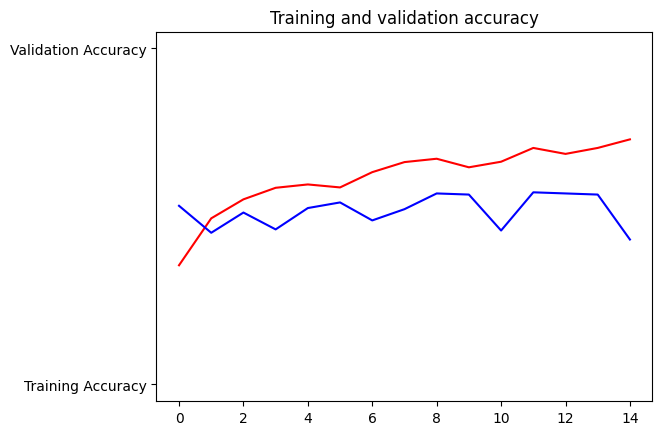

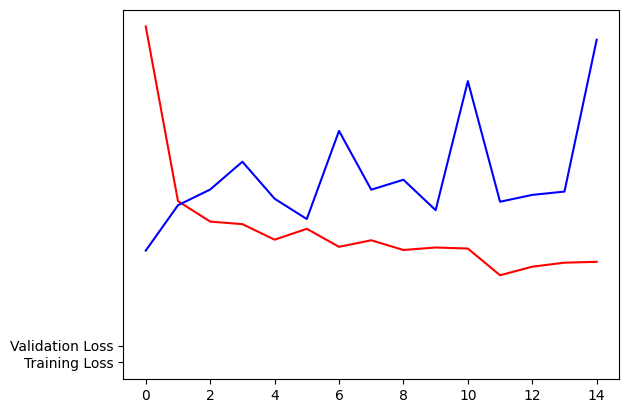

In [217]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [218]:
y_pred = model.predict(x_test_n).argmax(1)
y_true = y_test

In [219]:
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

set(lbl.inverse_transform(y_test))

{'CLOTHES', 'GLASS', 'METAL', 'PAPER', 'PLASTIC'}

In [220]:
from sklearn.metrics import classification_report

classes = ['CLOTHES', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']
print(classification_report(y_true=y_true,y_pred=y_pred,target_names=classes))

              precision    recall  f1-score   support

     CLOTHES       1.00      0.29      0.45        45
       GLASS       0.78      0.67      0.72        60
       METAL       0.41      0.89      0.56        28
       PAPER       0.39      0.97      0.55        62
     PLASTIC       1.00      0.20      0.33       106

    accuracy                           0.53       301
   macro avg       0.72      0.60      0.52       301
weighted avg       0.78      0.53      0.49       301



In [221]:
pred = model.predict(x_test_n)

def show_predictions(gambar):
    plt.figure(figsize=(5, 5))
    plt.imshow(x_test[gambar])
    data_asli = lbl.inverse_transform([y_test[gambar]])
    prediksi_label = lbl.inverse_transform([np.argmax(pred[gambar])])
    plt.title(f'Motif Asli: {data_asli[0]}\nPrediksi Motif: {prediksi_label[0]}')

interact(show_predictions, gambar=widgets.IntSlider(min=0, max=len(x_test) - 1, step=1, value=10))

interactive(children=(IntSlider(value=10, description='gambar', max=300), Output()), _dom_classes=('widget-int…

<function __main__.show_predictions(gambar)>

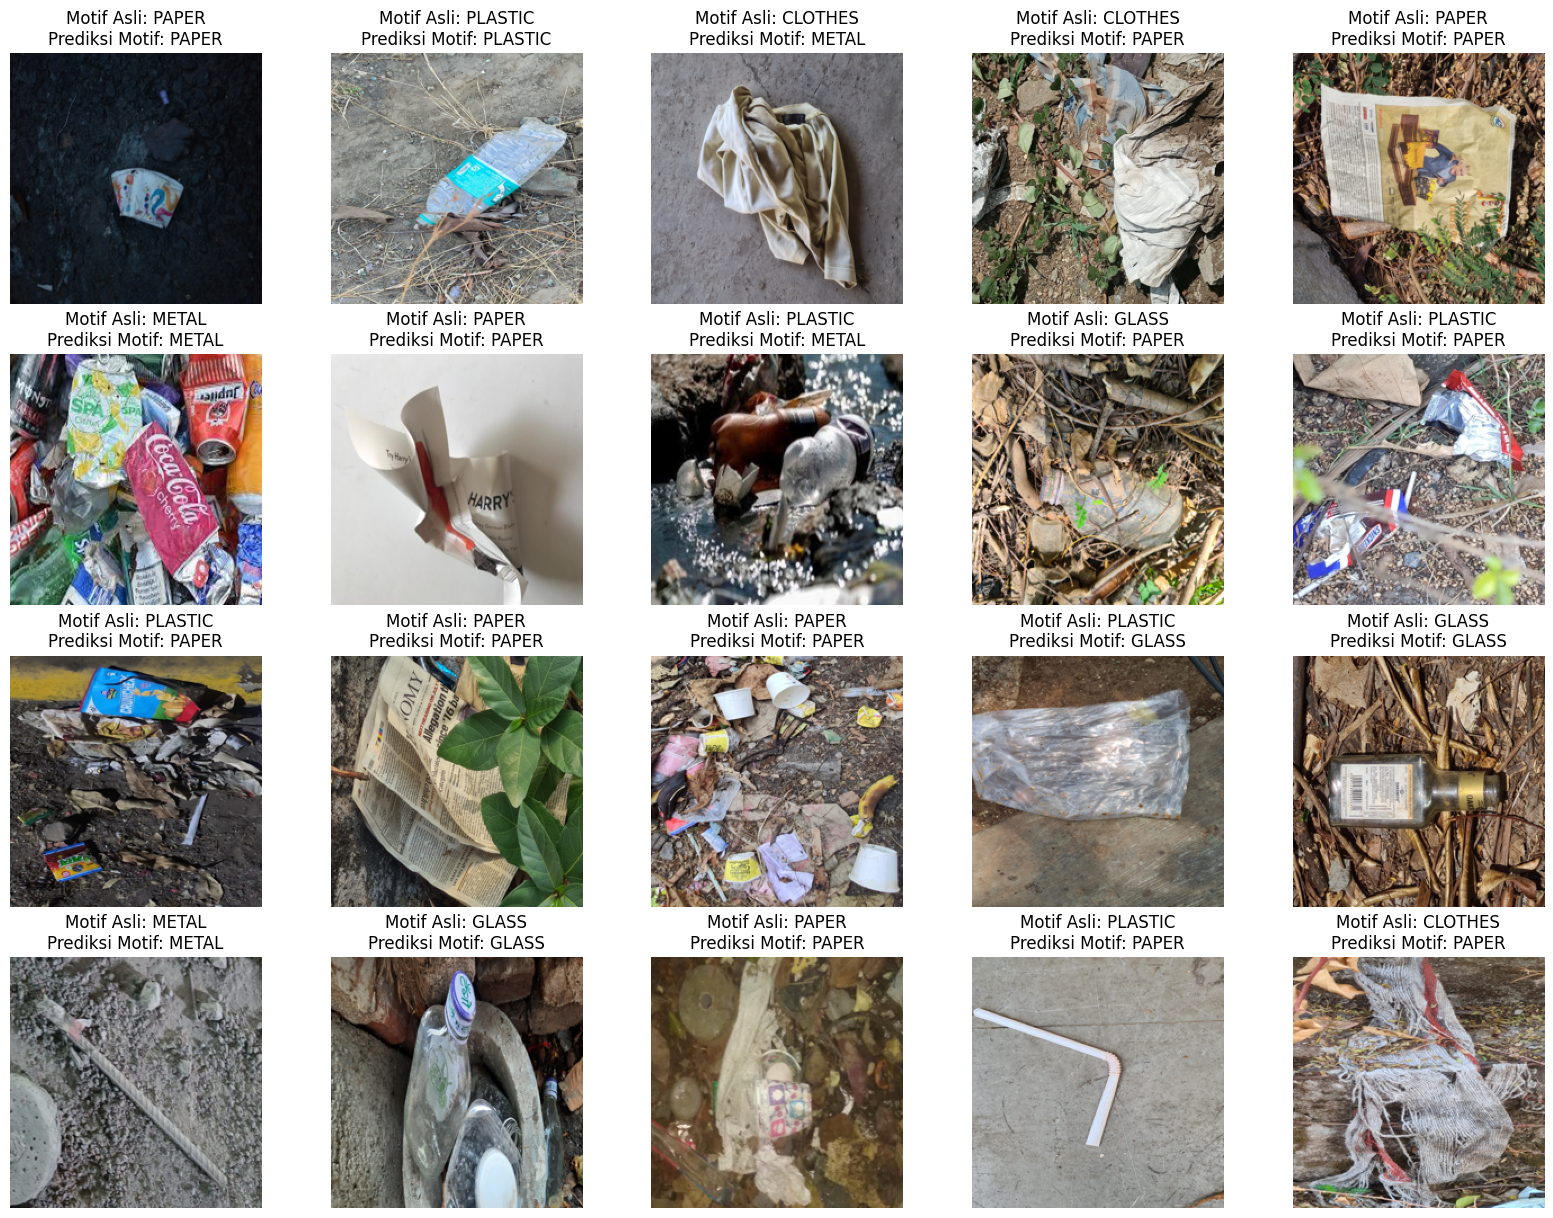

In [222]:
def show_all_predictions():
    plt.figure(figsize=(20, 15))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(x_test[i])
        data_asli = lbl.inverse_transform([y_test[i]])
        prediksi_label = lbl.inverse_transform([np.argmax(pred[i])])
        plt.title(f'Motif Asli: {data_asli[0]}\nPrediksi Motif: {prediksi_label[0]}')
        plt.axis('off')

show_all_predictions()

In [223]:
def show_all_predictions_per_class(class_name):
    plt.figure(figsize=(15, 10))
    
    class_indices = [i for i in range(len(x_test)) if classes[np.argmax(pred[i])] == class_name]
    
    for i, idx in enumerate(class_indices):
        plt.subplot(4, 5, i % 20 + 1)
        plt.imshow(x_test[idx])
        data_asli = classes[y_test[idx]]
        prediksi_label = classes[np.argmax(pred[idx])]
        plt.title(f'Motif Asli: {data_asli}\nPrediksi Motif: {prediksi_label}')
        plt.axis('off')

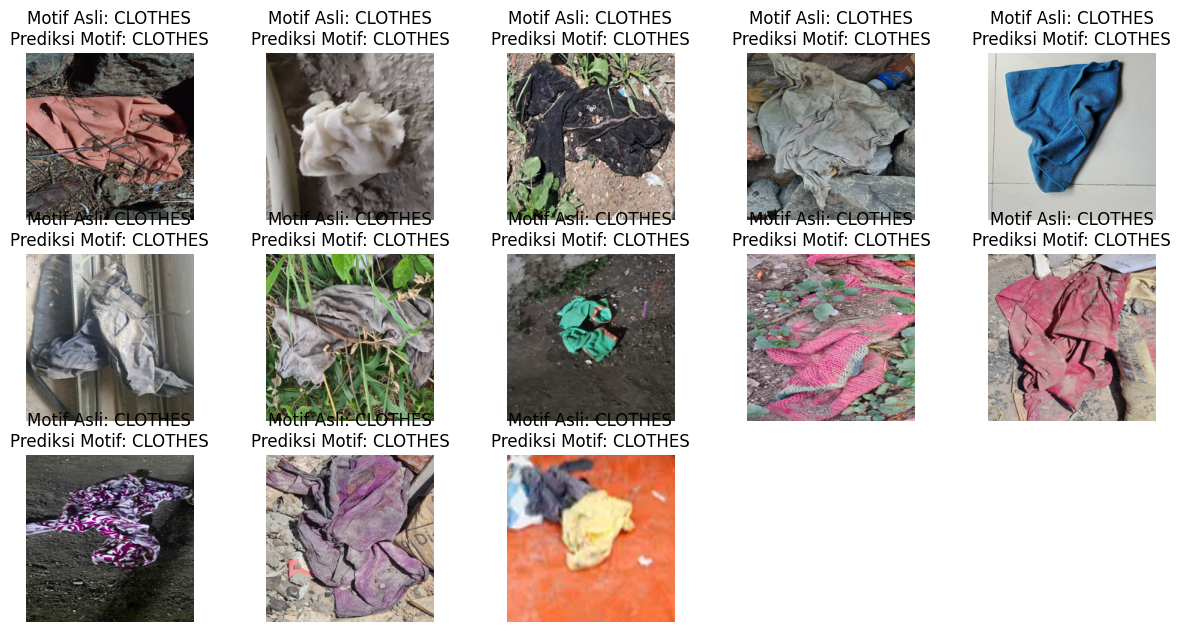

In [224]:
show_all_predictions_per_class('CLOTHES')
plt.show()

In [225]:
show_all_predictions_per_class('Cendrawasih')
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [226]:
show_all_predictions_per_class('Kawung')
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [227]:
show_all_predictions_per_class('Megamendung')
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [228]:
show_all_predictions_per_class('Parang')
plt.show()

<Figure size 1500x1000 with 0 Axes>

In [229]:
# Predictions on the test set
y_pred = model.predict(x_test_n)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to categorical labels
y_true_classes = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[13  0  8 24  0]
 [ 0 40  6 14  0]
 [ 0  0 25  3  0]
 [ 0  1  1 60  0]
 [ 0 10 21 54 21]]
